# CSE 610 Assignment 4: YOLO Object Detection on PASCAL VOC

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 唐嘉宏, M124111043.


## If you're using Google colab
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.If you're using Google Colab

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !ls #{your A4 path in google drive}

### Now, move to the directory of A4

In [3]:
# %cd #{your A4 path in google drive}

## If you're running locally

You should in the A4 directory unzipped from A4.zip now

## Setup the data

If you don't set up the dataset before, execute this block.

In [4]:
# %cd data

# # download train
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar -xf VOCtrainval_06-Nov-2007.tar
# !mv VOCdevkit VOCdevkit_2007
# !rm VOCtrainval_06-Nov-2007.tar

# # download test and combine into same directory
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
# !tar -xf VOCtest_06-Nov-2007.tar
# !mv VOCdevkit/VOC2007 VOCdevkit_2007/VOC2007test
# !rmdir VOCdevkit
# !rm VOCtest_06-Nov-2007.tar

# # MIRROR Links (comment out above and uncomment out below if host.robots.ox.au.uk is down)

# # !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
# # !tar -xf VOCtrainval_06-Nov-2007.tar
# # !mv VOCdevkit VOCdevkit_2007
# # !rm VOCtrainval_06-Nov-2007.tar

# # !wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
# # !tar -xf VOCtest_06-Nov-2007.tar
# # !mv VOCdevkit/VOC2007 VOCdevkit_2007/VOC2007test
# # !rmdir VOCdevkit
# # !rm VOCtest_06-Nov-2007.tar

# # now, cd back to A4
# %cd ..

# Import package

In [5]:
import os
import random

import cv2
import numpy as np

import csv

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate, test_evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import write_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Initialization

In [6]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [12]:
load_network_path = None #'checkpoints/best_detector.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [13]:
learning_rate = 0.001
num_epochs = 80
batch_size = 10

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

In [14]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007train.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 3756 train images


In [15]:
file_root_val = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_val = 'data/voc2007val.txt'

val_dataset = VocDetectorDataset(root_img_dir=file_root_val,dataset_file=annotation_file_val,train=False, S=S)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d val images' % len(val_dataset))

Initializing dataset
Loaded 1255 val images


In [ ]:
# data = train_dataset[0]

## Set up training tools

In [16]:
from torch.optim.lr_scheduler import MultiStepLR

criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Learning Rate Scheduler
# Reduce learning rate by a factor of 0.1 at epochs 30 and 40
scheduler = MultiStepLR(optimizer, milestones=[40, 60], gamma=0.1)

In [17]:
from ema_pytorch import EMA

alpha = 0.999 
global_step = 0 

ema = EMA(
    model=net,
    beta=0.9999,  
    update_after_step=100,  
    update_every=10,  
    
)

## Train detector

In [21]:
best_val_loss = np.inf
best_val_loss_ema = np.inf

# Open a file to write the metrics
for epoch in range(num_epochs):
    net.train()

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(optimizer.param_groups[0]['lr']))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

        # Update EMA after every training step
        ema.update()

    # Update EMA parameters after each epoch or training step
    global_step += 1

    # Evaluation using EMA model
    ema.eval()
    val_loss_ema = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = ema(images)  # Use EMA model for prediction
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            val_loss_ema += loss_dict['total_loss'].item()
        val_loss_ema /= len(val_loader)

    # Compare EMA validation loss to regular model validation loss
    if best_val_loss_ema > val_loss_ema:
        best_val_loss_ema = val_loss_ema
        print('Updating best val loss (EMA): %.5f' % best_val_loss_ema)
        torch.save(ema.state_dict(), 'checkpoints/best_detector_ema.pth')

    with torch.no_grad():
        val_loss = 0.0
        net.eval()
        for i, data in enumerate(val_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            val_loss += loss_dict['total_loss'].item()
        val_loss /= len(val_loader)

    if (epoch + 1) % 5 == 0:
        val_aps = torch.tensor(evaluate(net, val_dataset_file=annotation_file_val, img_root=file_root_val))
        val_aps_ema = torch.tensor(evaluate(ema, val_dataset_file=annotation_file_val, img_root=file_root_val))
    

    # Scheduler step
    scheduler.step()
    
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')




Starting epoch 1 / 80
Learning Rate for this epoch: 0.001
Epoch [1/80], Iter [50/376], Loss: total=25.917, reg=0.798, containing_obj=1.479, no_obj=25.361, cls=7.769
Epoch [1/80], Iter [100/376], Loss: total=18.116, reg=0.709, containing_obj=1.807, no_obj=13.176, cls=6.178
Epoch [1/80], Iter [150/376], Loss: total=14.895, reg=0.646, containing_obj=1.847, no_obj=9.024, cls=5.305
Epoch [1/80], Iter [200/376], Loss: total=13.242, reg=0.611, containing_obj=1.909, no_obj=6.914, cls=4.820
Epoch [1/80], Iter [250/376], Loss: total=12.200, reg=0.592, containing_obj=1.957, no_obj=5.633, cls=4.468
Epoch [1/80], Iter [300/376], Loss: total=11.419, reg=0.576, containing_obj=1.976, no_obj=4.771, cls=4.178
Epoch [1/80], Iter [350/376], Loss: total=10.793, reg=0.559, containing_obj=1.979, no_obj=4.153, cls=3.942
Updating best val loss (EMA): 8.24933


Starting epoch 2 / 80
Learning Rate for this epoch: 0.001
Epoch [2/80], Iter [50/376], Loss: total=7.143, reg=0.473, containing_obj=2.066, no_obj=0.45

100%|██████████| 1255/1255 [00:36<00:00, 34.69it/s]


---class aeroplane ap 0.05772093023255814---
---class bicycle ap 0.054987991251727514---
---class bird ap 0.014141414141414142---
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.028776223776223776---
---class car ap 0.4270430831502786---
---class cat ap 0.10501076581721742---
---class chair ap 0.0891553926853122---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.040652765548707274---
---class horse ap 0.09238726090191278---
---class motorbike ap 0.010869565217391304---
---class person ap 0.2963549832226139---
---class pottedplant ap 0.02326127819548872---
---class sheep ap 0.026881720430107524---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.06756756756756757---
---class tvmonitor ap 0.0228310502283105---
---map 0.06788209961834156---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:32<00:00, 38.26it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.06895126900548425---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.06929076096667938---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (n

100%|██████████| 1255/1255 [00:36<00:00, 34.16it/s]


---class aeroplane ap 0.338825540902348---
---class bicycle ap 0.2991132543373078---
---class bird ap 0.3033806442194428---
---class boat ap 0.1325201936565084---
---class bottle ap 0.09535900836207327---
---class bus ap 0.30905738682253914---
---class car ap 0.4589722905630416---
---class cat ap 0.35793940309535377---
---class chair ap 0.18950522114281193---
---class cow ap 0.0---
---class diningtable ap 0.07142857142857142---
---class dog ap 0.1774253816474863---
---class horse ap 0.3011468068407496---
---class motorbike ap 0.45339389607364733---
---class person ap 0.3468816772602309---
---class pottedplant ap 0.033015604669488885---
---class sheep ap 0.06527939670943333---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.4494590919178767---
---class tvmonitor ap 0.31724685334695646---
---map 0.23499751114979336---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.14it/s]


---class aeroplane ap 0.08500712909294801---
---class bicycle ap 0.06606488749345893---
---class bird ap 0.025252525252525252---
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0303030303030303---
---class car ap 0.4321797906447403---
---class cat ap 0.06420890937019968---
---class chair ap 0.06308164765813938---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.016129032258064516---
---class horse ap 0.11416490486257928---
---class motorbike ap 0.010869565217391304---
---class person ap 0.2836617649495464---
---class pottedplant ap 0.013157894736842105---
---class sheep ap 0.0032258064516129032---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0136986301369863---
---map 0.06105027592140323---


Starting epoch 11 / 80
Learning Rat

100%|██████████| 1255/1255 [00:36<00:00, 33.92it/s]


---class aeroplane ap 0.49779634797200595---
---class bicycle ap 0.4300398059265476---
---class bird ap 0.3595824775431647---
---class boat ap 0.22154569687427647---
---class bottle ap 0.13751322511298614---
---class bus ap 0.4846450999281985---
---class car ap 0.5172030871921418---
---class cat ap 0.5831555740818027---
---class chair ap 0.218764503438469---
---class cow ap 0.2749762453529884---
---class diningtable ap 0.14841269841269839---
---class dog ap 0.3460495565814086---
---class horse ap 0.4708638818338089---
---class motorbike ap 0.5634949579703032---
---class person ap 0.4024332264091841---
---class pottedplant ap 0.10785665914591838---
---class sheep ap 0.16673946336179274---
---class sofa ap 0.25439200805580114---
---class train ap 0.630479638266078---
---class tvmonitor ap 0.47249473383874835---
---map 0.3644219443649162---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:37<00:00, 33.64it/s]


---class aeroplane ap 0.29979771558991036---
---class bicycle ap 0.345065393850212---
---class bird ap 0.2757534674383325---
---class boat ap 0.12495540431700274---
---class bottle ap 0.05541796788775032---
---class bus ap 0.2848023715415019---
---class car ap 0.558819292464676---
---class cat ap 0.3453411316980688---
---class chair ap 0.14752296288824757---
---class cow ap 0.054987212276214836---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.19374122166703575---
---class horse ap 0.31777079086104626---
---class motorbike ap 0.30763100854264946---
---class person ap 0.4078398713873007---
---class pottedplant ap 0.08568697050186737---
---class sheep ap 0.13037339123297517---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.4022011603261604---
---class tvmonitor ap 0.2810552718863695---
---map 0.23093813031786609---


Starting epoch 16 / 80
Learning Rate for this epoch: 0.001
Epoch [16/80], Iter [50/376], Loss: total=3.409, re

100%|██████████| 1255/1255 [00:38<00:00, 32.68it/s]


---class aeroplane ap 0.6546243198283144---
---class bicycle ap 0.5354956542410075---
---class bird ap 0.37457411768457016---
---class boat ap 0.28397543871708125---
---class bottle ap 0.16362781006783414---
---class bus ap 0.4504860392807634---
---class car ap 0.6318966598112039---
---class cat ap 0.6055051206303006---
---class chair ap 0.29459027666848847---
---class cow ap 0.28661364917707566---
---class diningtable ap 0.41862039838230314---
---class dog ap 0.4794612181920635---
---class horse ap 0.4461683833120443---
---class motorbike ap 0.5613344813202646---
---class person ap 0.45783098952912893---
---class pottedplant ap 0.14164607512227484---
---class sheep ap 0.20535973976664174---
---class sofa ap 0.3740984185555759---
---class train ap 0.5787653638110335---
---class tvmonitor ap 0.49621050587066---
---map 0.42204423299843147---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:36<00:00, 33.94it/s]


---class aeroplane ap 0.39643806701464857---
---class bicycle ap 0.4642894095579517---
---class bird ap 0.4462442981309781---
---class boat ap 0.1831818266158576---
---class bottle ap 0.1369874031687823---
---class bus ap 0.4544276413241931---
---class car ap 0.6060562168435211---
---class cat ap 0.5907614379874635---
---class chair ap 0.2556565095640481---
---class cow ap 0.15115089514066496---
---class diningtable ap 0.031746031746031744---
---class dog ap 0.40762836905049593---
---class horse ap 0.43649911442504974---
---class motorbike ap 0.46234982837528604---
---class person ap 0.4644879713726334---
---class pottedplant ap 0.16861330421198198---
---class sheep ap 0.18558563436468511---
---class sofa ap 0.1111111111111111---
---class train ap 0.6223998772868033---
---class tvmonitor ap 0.4700738024342593---
---map 0.3522844374863224---


Starting epoch 21 / 80
Learning Rate for this epoch: 0.001
Epoch [21/80], Iter [50/376], Loss: total=3.206, reg=0.238, containing_obj=1.174, no_o

100%|██████████| 1255/1255 [00:36<00:00, 34.75it/s]


---class aeroplane ap 0.521189191275566---
---class bicycle ap 0.6091654777088344---
---class bird ap 0.5057531552104241---
---class boat ap 0.22161362351353459---
---class bottle ap 0.146990923276558---
---class bus ap 0.5285009499782686---
---class car ap 0.6029221452513778---
---class cat ap 0.6173258458193107---
---class chair ap 0.27356932880793394---
---class cow ap 0.467662059938184---
---class diningtable ap 0.33571409942391744---
---class dog ap 0.5734463144339698---
---class horse ap 0.5648391766666652---
---class motorbike ap 0.6170467747096048---
---class person ap 0.4185208561375967---
---class pottedplant ap 0.19466464968145383---
---class sheep ap 0.3087419208405012---
---class sofa ap 0.42359579753618604---
---class train ap 0.6168637968151758---
---class tvmonitor ap 0.515274194119451---
---map 0.4531700140572257---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:35<00:00, 35.77it/s]


---class aeroplane ap 0.48837109244206467---
---class bicycle ap 0.5293193085066109---
---class bird ap 0.5136132759694714---
---class boat ap 0.2248894737656849---
---class bottle ap 0.1383832220000068---
---class bus ap 0.4738768929292208---
---class car ap 0.626977659711021---
---class cat ap 0.6827056197455721---
---class chair ap 0.29609873402169934---
---class cow ap 0.2764142648603634---
---class diningtable ap 0.1918083900226757---
---class dog ap 0.48672675716841446---
---class horse ap 0.5102598991020822---
---class motorbike ap 0.48322206583076155---
---class person ap 0.48263595080407984---
---class pottedplant ap 0.2181485893254301---
---class sheep ap 0.21056824163543308---
---class sofa ap 0.23302469135802467---
---class train ap 0.6927814006581675---
---class tvmonitor ap 0.5588491874737576---
---map 0.41593373586652704---


Starting epoch 26 / 80
Learning Rate for this epoch: 0.001
Epoch [26/80], Iter [50/376], Loss: total=2.929, reg=0.214, containing_obj=1.097, no_obj

100%|██████████| 1255/1255 [00:36<00:00, 34.45it/s]


---class aeroplane ap 0.6178575866106031---
---class bicycle ap 0.5928819432651193---
---class bird ap 0.48402186565526706---
---class boat ap 0.2965882256931982---
---class bottle ap 0.14175773575338158---
---class bus ap 0.5441737232956745---
---class car ap 0.6898506889339231---
---class cat ap 0.6419478877469811---
---class chair ap 0.2957351045246942---
---class cow ap 0.42435929457696514---
---class diningtable ap 0.38004157751766654---
---class dog ap 0.5257664736805816---
---class horse ap 0.5814940167494906---
---class motorbike ap 0.5057256065863196---
---class person ap 0.4475914314341526---
---class pottedplant ap 0.26070632655692355---
---class sheep ap 0.26655517405624074---
---class sofa ap 0.5141888917759232---
---class train ap 0.7111042915891287---
---class tvmonitor ap 0.5373194535673269---
---map 0.472983364978478---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.52it/s]


---class aeroplane ap 0.5681517235030801---
---class bicycle ap 0.5974622645704447---
---class bird ap 0.5359311647094314---
---class boat ap 0.2679295019940349---
---class bottle ap 0.1963140441767574---
---class bus ap 0.5493281397538653---
---class car ap 0.674796454118224---
---class cat ap 0.7262660958033276---
---class chair ap 0.32584704277584947---
---class cow ap 0.3630606466362675---
---class diningtable ap 0.23333333333333334---
---class dog ap 0.5492400153972027---
---class horse ap 0.5454909586027595---
---class motorbike ap 0.5279986772739125---
---class person ap 0.506575954705408---
---class pottedplant ap 0.24716574873701272---
---class sheep ap 0.2041051529978998---
---class sofa ap 0.3629289215686275---
---class train ap 0.7250956900877604---
---class tvmonitor ap 0.5680556224234393---
---map 0.4637538576584319---


Starting epoch 31 / 80
Learning Rate for this epoch: 0.001
Epoch [31/80], Iter [50/376], Loss: total=2.883, reg=0.212, containing_obj=1.081, no_obj=0.915

100%|██████████| 1255/1255 [00:34<00:00, 36.45it/s]


---class aeroplane ap 0.66388163079755---
---class bicycle ap 0.534004148315895---
---class bird ap 0.4908970266517759---
---class boat ap 0.2668590796758634---
---class bottle ap 0.22069048383516623---
---class bus ap 0.5008576090822364---
---class car ap 0.6672648004333306---
---class cat ap 0.7071829335923281---
---class chair ap 0.3217148381827006---
---class cow ap 0.4864561573800713---
---class diningtable ap 0.32903492974042375---
---class dog ap 0.5346481043478017---
---class horse ap 0.4915005737868576---
---class motorbike ap 0.4606684965182388---
---class person ap 0.5135177002653126---
---class pottedplant ap 0.2589315446533066---
---class sheep ap 0.26542580554106715---
---class sofa ap 0.45079352874007705---
---class train ap 0.7253185709366912---
---class tvmonitor ap 0.6018566159769375---
---map 0.47457522892268156---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.54it/s]


---class aeroplane ap 0.5257969967725088---
---class bicycle ap 0.644611900315823---
---class bird ap 0.548806992686221---
---class boat ap 0.3095419821518678---
---class bottle ap 0.20363854880165122---
---class bus ap 0.5856553933313676---
---class car ap 0.6711476573804831---
---class cat ap 0.7817098689056571---
---class chair ap 0.36856337028555575---
---class cow ap 0.41586181558510626---
---class diningtable ap 0.3072923989590657---
---class dog ap 0.6047383253890191---
---class horse ap 0.5722393280414887---
---class motorbike ap 0.5963335117091232---
---class person ap 0.5160944841499713---
---class pottedplant ap 0.2618123484011252---
---class sheep ap 0.25346971200235136---
---class sofa ap 0.38943027178914286---
---class train ap 0.7320570403881577---
---class tvmonitor ap 0.6289526112889612---
---map 0.4958877279167324---


Starting epoch 36 / 80
Learning Rate for this epoch: 0.001
Epoch [36/80], Iter [50/376], Loss: total=2.765, reg=0.200, containing_obj=1.053, no_obj=0.9

100%|██████████| 1255/1255 [00:34<00:00, 36.72it/s]


---class aeroplane ap 0.6640250509448097---
---class bicycle ap 0.6265530844156448---
---class bird ap 0.4713379327135204---
---class boat ap 0.29697057344344585---
---class bottle ap 0.287165932596543---
---class bus ap 0.5222369943028831---
---class car ap 0.6438250878529663---
---class cat ap 0.642659949107172---
---class chair ap 0.3296754450358814---
---class cow ap 0.5035050371770939---
---class diningtable ap 0.3766052107863702---
---class dog ap 0.5259509437276646---
---class horse ap 0.6086845636272449---
---class motorbike ap 0.5599675527252159---
---class person ap 0.5353300517716598---
---class pottedplant ap 0.24892329497184496---
---class sheep ap 0.21420743622014432---
---class sofa ap 0.43144427808700125---
---class train ap 0.7433051386360432---
---class tvmonitor ap 0.6199315486188168---
---map 0.4926152553380983---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.48it/s]


---class aeroplane ap 0.5986526118479429---
---class bicycle ap 0.6614985132007547---
---class bird ap 0.5180483864397628---
---class boat ap 0.3218090292695787---
---class bottle ap 0.1917234091548593---
---class bus ap 0.5687755604828776---
---class car ap 0.6933112795431707---
---class cat ap 0.7947632735962007---
---class chair ap 0.38214948125981313---
---class cow ap 0.47314437221148026---
---class diningtable ap 0.3042648646229209---
---class dog ap 0.5897300980532441---
---class horse ap 0.6094786806474484---
---class motorbike ap 0.5976330789373783---
---class person ap 0.52492154567289---
---class pottedplant ap 0.2763553925401106---
---class sheep ap 0.2232217255549545---
---class sofa ap 0.41461275550480947---
---class train ap 0.7885236326053182---
---class tvmonitor ap 0.6527819804896381---
---map 0.5092699835817578---


Starting epoch 41 / 80
Learning Rate for this epoch: 0.0001
Epoch [41/80], Iter [50/376], Loss: total=2.422, reg=0.170, containing_obj=0.936, no_obj=0.89

100%|██████████| 1255/1255 [00:33<00:00, 36.98it/s]


---class aeroplane ap 0.6856573987747514---
---class bicycle ap 0.7148096194752215---
---class bird ap 0.5132772096091174---
---class boat ap 0.31263047966964524---
---class bottle ap 0.2977414796662378---
---class bus ap 0.595589621223642---
---class car ap 0.6960936562199873---
---class cat ap 0.7744058484161866---
---class chair ap 0.361132723448166---
---class cow ap 0.5247620726240325---
---class diningtable ap 0.43116008104567016---
---class dog ap 0.6045475950934499---
---class horse ap 0.6868098114880322---
---class motorbike ap 0.6324777151221948---
---class person ap 0.5542332310989458---
---class pottedplant ap 0.24277580666324203---
---class sheep ap 0.27958235273057963---
---class sofa ap 0.44746052799813024---
---class train ap 0.8316665291879629---
---class tvmonitor ap 0.5988923120437821---
---map 0.539285303579949---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:33<00:00, 37.05it/s]


---class aeroplane ap 0.648641939413229---
---class bicycle ap 0.6865102351507162---
---class bird ap 0.5374230057932472---
---class boat ap 0.2920530569942127---
---class bottle ap 0.20590293762059442---
---class bus ap 0.5673575190648361---
---class car ap 0.7137911985748215---
---class cat ap 0.8377104705980525---
---class chair ap 0.3882092601710767---
---class cow ap 0.500102919573619---
---class diningtable ap 0.37416833942248995---
---class dog ap 0.5735182844035587---
---class horse ap 0.641250383319969---
---class motorbike ap 0.6391350263808189---
---class person ap 0.533158711958658---
---class pottedplant ap 0.2700468569691983---
---class sheep ap 0.1846692384056311---
---class sofa ap 0.4895273892232409---
---class train ap 0.79265307393958---
---class tvmonitor ap 0.6625974657290714---
---map 0.526921365635331---


Starting epoch 46 / 80
Learning Rate for this epoch: 0.0001
Epoch [46/80], Iter [50/376], Loss: total=2.077, reg=0.144, containing_obj=0.775, no_obj=0.918, cls

100%|██████████| 1255/1255 [00:34<00:00, 36.24it/s]


---class aeroplane ap 0.6041120100627624---
---class bicycle ap 0.7246281305632595---
---class bird ap 0.5310497289518671---
---class boat ap 0.29186378617013314---
---class bottle ap 0.31808611486280225---
---class bus ap 0.6105719112729723---
---class car ap 0.6922667858987868---
---class cat ap 0.7509705151545839---
---class chair ap 0.3715110680272313---
---class cow ap 0.4998279128284465---
---class diningtable ap 0.44419615258670564---
---class dog ap 0.5816997424688308---
---class horse ap 0.6864153689792284---
---class motorbike ap 0.6032984984754651---
---class person ap 0.5437778456731441---
---class pottedplant ap 0.2739643102595728---
---class sheep ap 0.2873121249671558---
---class sofa ap 0.4942585335672162---
---class train ap 0.8185700403532185---
---class tvmonitor ap 0.6255279181966941---
---map 0.5376954249660038---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.89it/s]


---class aeroplane ap 0.6861025627199373---
---class bicycle ap 0.7099194459056746---
---class bird ap 0.590252806637922---
---class boat ap 0.29282420588989616---
---class bottle ap 0.23784093947326992---
---class bus ap 0.5847091640508568---
---class car ap 0.7114398403407007---
---class cat ap 0.8326270426278382---
---class chair ap 0.3882731347952385---
---class cow ap 0.5111403118955278---
---class diningtable ap 0.4483146350632826---
---class dog ap 0.5671836883723098---
---class horse ap 0.6518418207348182---
---class motorbike ap 0.641516706721418---
---class person ap 0.5524007509337798---
---class pottedplant ap 0.27458552074918163---
---class sheep ap 0.21409363114496963---
---class sofa ap 0.5033022391581689---
---class train ap 0.8078910126938438---
---class tvmonitor ap 0.6680133209018158---
---map 0.5437136390405225---


Starting epoch 51 / 80
Learning Rate for this epoch: 0.0001
Epoch [51/80], Iter [50/376], Loss: total=2.025, reg=0.128, containing_obj=0.816, no_obj=0.9

100%|██████████| 1255/1255 [00:33<00:00, 37.27it/s]


---class aeroplane ap 0.635729203577727---
---class bicycle ap 0.6868049812408205---
---class bird ap 0.5518719090750099---
---class boat ap 0.32469962043532274---
---class bottle ap 0.3327582054572681---
---class bus ap 0.5889067978840706---
---class car ap 0.6797067222481761---
---class cat ap 0.7845168705490403---
---class chair ap 0.3723931739866943---
---class cow ap 0.49331010509945167---
---class diningtable ap 0.44350609426684123---
---class dog ap 0.5850348531305095---
---class horse ap 0.6737485677348379---
---class motorbike ap 0.5975411655199031---
---class person ap 0.5537132712865047---
---class pottedplant ap 0.25226740998427716---
---class sheep ap 0.3276461606264847---
---class sofa ap 0.502286915581078---
---class train ap 0.7917349972728215---
---class tvmonitor ap 0.6181741127216065---
---map 0.5398175568839222---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:47<00:00, 26.65it/s]


---class aeroplane ap 0.6843982572826063---
---class bicycle ap 0.695948051950141---
---class bird ap 0.5916665421834998---
---class boat ap 0.33726803695130364---
---class bottle ap 0.2673167120441545---
---class bus ap 0.5815812704667193---
---class car ap 0.7035561232797161---
---class cat ap 0.8307945102205803---
---class chair ap 0.3988876254145431---
---class cow ap 0.5163459262802317---
---class diningtable ap 0.4544601397298331---
---class dog ap 0.5698664071936608---
---class horse ap 0.6526418512484038---
---class motorbike ap 0.6252658515844778---
---class person ap 0.5567453564185859---
---class pottedplant ap 0.2769793383573881---
---class sheep ap 0.24383872297469172---
---class sofa ap 0.49640224086712903---
---class train ap 0.7999602419243224---
---class tvmonitor ap 0.654457359658182---
---map 0.5469190283015085---


Starting epoch 56 / 80
Learning Rate for this epoch: 0.0001
Epoch [56/80], Iter [50/376], Loss: total=2.188, reg=0.144, containing_obj=0.843, no_obj=1.03

100%|██████████| 1255/1255 [00:34<00:00, 36.83it/s]


---class aeroplane ap 0.6528187421096188---
---class bicycle ap 0.7191371925532242---
---class bird ap 0.5970607540398772---
---class boat ap 0.326851049387888---
---class bottle ap 0.3357914055341874---
---class bus ap 0.6080417326302814---
---class car ap 0.6843637189971776---
---class cat ap 0.7712361016667811---
---class chair ap 0.3889185249135641---
---class cow ap 0.5256786280379342---
---class diningtable ap 0.42291821013082304---
---class dog ap 0.5857388850314642---
---class horse ap 0.7471082398574952---
---class motorbike ap 0.6367121403060501---
---class person ap 0.5691563833121709---
---class pottedplant ap 0.27159417149131077---
---class sheep ap 0.401485893845826---
---class sofa ap 0.5015622964956284---
---class train ap 0.7779356040254002---
---class tvmonitor ap 0.6339716724407939---
---map 0.5579040673403749---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:33<00:00, 37.06it/s]


---class aeroplane ap 0.6798910793871531---
---class bicycle ap 0.6986918446655811---
---class bird ap 0.561346958628943---
---class boat ap 0.3304940074994759---
---class bottle ap 0.2945921200106736---
---class bus ap 0.5819880584396712---
---class car ap 0.7050273891811717---
---class cat ap 0.8277696633143877---
---class chair ap 0.38938520909947827---
---class cow ap 0.5237030579876722---
---class diningtable ap 0.4610981153551001---
---class dog ap 0.5682069246583901---
---class horse ap 0.6548401749608482---
---class motorbike ap 0.6213734155765261---
---class person ap 0.5619897788816431---
---class pottedplant ap 0.28195361075207387---
---class sheep ap 0.25097486220209764---
---class sofa ap 0.4917705800067679---
---class train ap 0.8037075582204689---
---class tvmonitor ap 0.6543874499332337---
---map 0.5471595929380679---


Starting epoch 61 / 80
Learning Rate for this epoch: 1e-05
Epoch [61/80], Iter [50/376], Loss: total=2.054, reg=0.131, containing_obj=0.787, no_obj=0.97

100%|██████████| 1255/1255 [00:36<00:00, 34.86it/s]


---class aeroplane ap 0.6295023658897695---
---class bicycle ap 0.6991472481079641---
---class bird ap 0.5466047382550897---
---class boat ap 0.34417060252032716---
---class bottle ap 0.29661618702317954---
---class bus ap 0.5922413378006472---
---class car ap 0.6937501887284605---
---class cat ap 0.776310417498332---
---class chair ap 0.3874545859256733---
---class cow ap 0.5365806064001271---
---class diningtable ap 0.3733303338393651---
---class dog ap 0.6079322507403621---
---class horse ap 0.7153174946761167---
---class motorbike ap 0.5952539095788524---
---class person ap 0.5699148197338395---
---class pottedplant ap 0.28712475302499607---
---class sheep ap 0.3364778635630615---
---class sofa ap 0.43162374279758003---
---class train ap 0.7747852411410149---
---class tvmonitor ap 0.6341933186031818---
---map 0.541416600292397---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:36<00:00, 33.96it/s]


---class aeroplane ap 0.6745851637801621---
---class bicycle ap 0.7230946967258303---
---class bird ap 0.5612206429166764---
---class boat ap 0.35364970095030135---
---class bottle ap 0.29217394840200583---
---class bus ap 0.5839825737363937---
---class car ap 0.7054074744085879---
---class cat ap 0.8101611148929104---
---class chair ap 0.3785912740045793---
---class cow ap 0.5113837992291833---
---class diningtable ap 0.47311052380981705---
---class dog ap 0.5919569258882785---
---class horse ap 0.6678510094271892---
---class motorbike ap 0.6294246659643931---
---class person ap 0.5588260712003056---
---class pottedplant ap 0.27290988175693515---
---class sheep ap 0.2961794974096514---
---class sofa ap 0.4545652637378661---
---class train ap 0.7979677191855481---
---class tvmonitor ap 0.6632897210812798---
---map 0.5500165834253947---


Starting epoch 66 / 80
Learning Rate for this epoch: 1e-05
Epoch [66/80], Iter [50/376], Loss: total=1.917, reg=0.118, containing_obj=0.751, no_obj=0.

100%|██████████| 1255/1255 [00:34<00:00, 36.08it/s]


---class aeroplane ap 0.6436198665988484---
---class bicycle ap 0.6905591152300314---
---class bird ap 0.556607877152684---
---class boat ap 0.3088817624637087---
---class bottle ap 0.3215448195853298---
---class bus ap 0.607387775608539---
---class car ap 0.6925972750367405---
---class cat ap 0.7518482635816488---
---class chair ap 0.3884856615462697---
---class cow ap 0.5237093583729533---
---class diningtable ap 0.4294326322635612---
---class dog ap 0.6149079762991153---
---class horse ap 0.6918297764993665---
---class motorbike ap 0.6070316702492934---
---class person ap 0.5656228090376837---
---class pottedplant ap 0.26364838119075895---
---class sheep ap 0.35615522349665585---
---class sofa ap 0.44866259213889526---
---class train ap 0.7833395833153602---
---class tvmonitor ap 0.6370747071592812---
---map 0.5441473563413363---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.90it/s]


---class aeroplane ap 0.6529323744512423---
---class bicycle ap 0.7221577953859235---
---class bird ap 0.5546989483888511---
---class boat ap 0.33651236523893213---
---class bottle ap 0.3199737110789242---
---class bus ap 0.5849334359470685---
---class car ap 0.6977113139992792---
---class cat ap 0.8000815351472992---
---class chair ap 0.39783367700590755---
---class cow ap 0.5136559375982968---
---class diningtable ap 0.5053688671338422---
---class dog ap 0.6016708445981442---
---class horse ap 0.6794683926897008---
---class motorbike ap 0.6190967205451858---
---class person ap 0.5593524109242346---
---class pottedplant ap 0.27309259151165166---
---class sheep ap 0.3410055206634763---
---class sofa ap 0.4595884185371014---
---class train ap 0.7935074996158006---
---class tvmonitor ap 0.6628801974458498---
---map 0.5537761278953356---


Starting epoch 71 / 80
Learning Rate for this epoch: 1e-05
Epoch [71/80], Iter [50/376], Loss: total=2.183, reg=0.149, containing_obj=0.850, no_obj=0.9

100%|██████████| 1255/1255 [00:34<00:00, 36.89it/s]


---class aeroplane ap 0.6451607002302037---
---class bicycle ap 0.7038038178059632---
---class bird ap 0.5764441217077868---
---class boat ap 0.31727795785012053---
---class bottle ap 0.31836578627037776---
---class bus ap 0.6271200953019134---
---class car ap 0.7057838367863856---
---class cat ap 0.8108147533645654---
---class chair ap 0.3919183441573144---
---class cow ap 0.5209698466428554---
---class diningtable ap 0.4219157959648619---
---class dog ap 0.6103241475615331---
---class horse ap 0.7285071086711707---
---class motorbike ap 0.5777872958568773---
---class person ap 0.567688078282935---
---class pottedplant ap 0.2627222880008854---
---class sheep ap 0.37756329228723035---
---class sofa ap 0.45433294585549644---
---class train ap 0.8156445077953721---
---class tvmonitor ap 0.632880003741749---
---map 0.5533512362067798---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:33<00:00, 37.04it/s]


---class aeroplane ap 0.6337681597852055---
---class bicycle ap 0.7213062269591024---
---class bird ap 0.558449304177417---
---class boat ap 0.3198576789037015---
---class bottle ap 0.31140724930890995---
---class bus ap 0.6033018851766077---
---class car ap 0.696321361207731---
---class cat ap 0.8091988664885903---
---class chair ap 0.3975606345566264---
---class cow ap 0.5040712048230857---
---class diningtable ap 0.4695927794028236---
---class dog ap 0.5955295176664317---
---class horse ap 0.6896208462257506---
---class motorbike ap 0.6187114690597342---
---class person ap 0.5591466672782389---
---class pottedplant ap 0.2839498128694744---
---class sheep ap 0.346128375672386---
---class sofa ap 0.4583064373359789---
---class train ap 0.8016937691523506---
---class tvmonitor ap 0.6467088475609979---
---map 0.5512315546805573---


Starting epoch 76 / 80
Learning Rate for this epoch: 1e-05
Epoch [76/80], Iter [50/376], Loss: total=2.168, reg=0.144, containing_obj=0.850, no_obj=0.967, c

100%|██████████| 1255/1255 [00:33<00:00, 37.41it/s]


---class aeroplane ap 0.6476733386319782---
---class bicycle ap 0.6976460123320412---
---class bird ap 0.5490088023670991---
---class boat ap 0.327770540285283---
---class bottle ap 0.3241738527244669---
---class bus ap 0.5767134258476465---
---class car ap 0.6943420121353249---
---class cat ap 0.7755969651550572---
---class chair ap 0.38292782785439605---
---class cow ap 0.5270824326525934---
---class diningtable ap 0.4131889228172925---
---class dog ap 0.6003791592762241---
---class horse ap 0.7074026275947398---
---class motorbike ap 0.6155449561366353---
---class person ap 0.5647784159346589---
---class pottedplant ap 0.26822724978776774---
---class sheep ap 0.34212487652642176---
---class sofa ap 0.48276217262563076---
---class train ap 0.7858025362858427---
---class tvmonitor ap 0.6478997449643957---
---map 0.5465522935967748---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:33<00:00, 37.16it/s]


---class aeroplane ap 0.6307760357820521---
---class bicycle ap 0.7296433207947983---
---class bird ap 0.5447164957344274---
---class boat ap 0.33884166529090676---
---class bottle ap 0.3067489957219181---
---class bus ap 0.6215865358319191---
---class car ap 0.6958737667683039---
---class cat ap 0.8083224055907513---
---class chair ap 0.38498582748762306---
---class cow ap 0.5053380139326998---
---class diningtable ap 0.4698517094569773---
---class dog ap 0.6066850587043745---
---class horse ap 0.6904243688265784---
---class motorbike ap 0.6185812551860813---
---class person ap 0.5585886096319768---
---class pottedplant ap 0.28046619425717395---
---class sheep ap 0.327233846556283---
---class sofa ap 0.49017064310565006---
---class train ap 0.8143353282284965---
---class tvmonitor ap 0.64965689718884---
---map 0.5536413487038916---


# View example predictions

In [28]:
load_network_path = 'checkpoints/best_detector_ema.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    ema.load_state_dict(torch.load(load_network_path))

Loading saved network from checkpoints/best_detector_ema.pth


C:\Users\User\AppData\Local\Temp\ipykernel_35076\2032766669.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ema.load_state_dict(torch.load(load_network_path))


In [29]:
val_aps = evaluate(ema, val_dataset_file=annotation_file_val, img_root=file_root_val)

---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:36<00:00, 34.24it/s]


---class aeroplane ap 0.688099441596775---
---class bicycle ap 0.7069115495791529---
---class bird ap 0.5924011814995906---
---class boat ap 0.31519858908917164---
---class bottle ap 0.2590072179221395---
---class bus ap 0.5846272032968265---
---class car ap 0.7000472730952116---
---class cat ap 0.8312649774950502---
---class chair ap 0.38465467879648985---
---class cow ap 0.5196911771387034---
---class diningtable ap 0.45783213341352874---
---class dog ap 0.5685288948196934---
---class horse ap 0.6526290475667141---
---class motorbike ap 0.6370211902269259---
---class person ap 0.5589591518108146---
---class pottedplant ap 0.2770861272349219---
---class sheep ap 0.23207241227451336---
---class sofa ap 0.4807203039508064---
---class train ap 0.8098895634654212---
---class tvmonitor ap 0.6531798970776228---
---map 0.5454911005675037---


predicting...


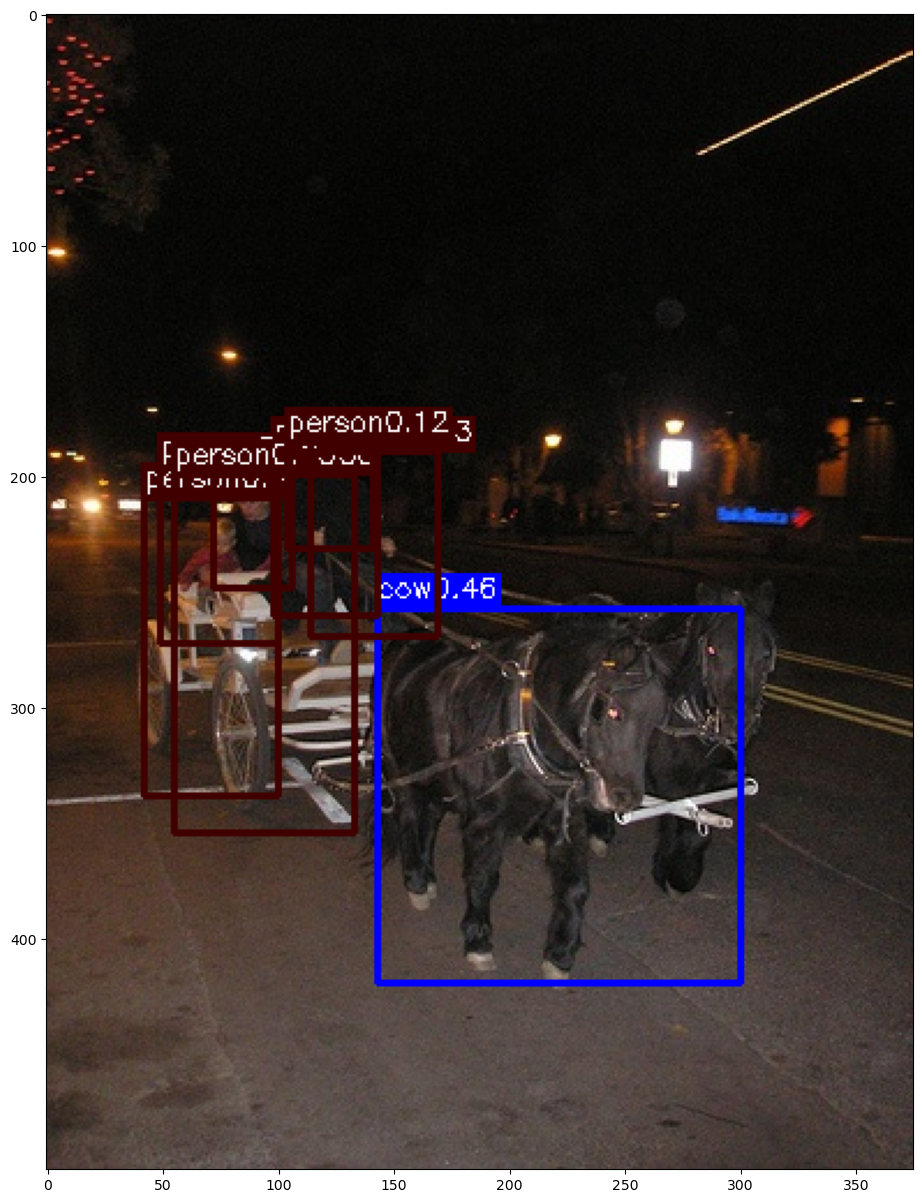

In [30]:
ema.eval()

# select random image from val set
image_name = random.choice(val_dataset.fnames)
image = cv2.imread(os.path.join(file_root_val, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.style.use('default')

print('predicting...')
result = predict_image(ema, image_name, root_img_directory=file_root_val)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)

# Kaggle submission (85%)

### Predict Result

Predict the results based on testing set. Upload to Kaggle.

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.

---

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中50%資料的正確率

In [31]:
root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
file_test = 'data/voc2007test.txt'


By using the test_evaluate function, you will obtain predictions for each image.

In [32]:
preds_submission = test_evaluate(ema, test_dataset_file=file_test, img_root=root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:18<00:00, 35.62it/s]


The write_csv function will use preds_submission to write into a CSV file called 'result.csv'.

In [33]:
write_csv(preds_submission)

# Report (15%)
In your report, please include:

a. A brief discussion on your implementation.

b. Report the best train and validation accuracy in all of your experiments and discuss
any strategies or tricks you’ve employed.

c. Report the results for extra credits and also provide a discussion, if any.

# Extra Credit (15%)

• Pick a fun video like [**this one**](https://www.youtube.com/watch?v=xZGahvrep3o), run your detector on it (a subset of frames would be
OK), and produce a video showing your results.

• Try to replace the provided pre-trained network with a different one and train with
the YOLO loss on top to attempt to get better accuracy.

• Or any other methods that you try to improve the performance.